<a href="https://colab.research.google.com/github/Abdul-git25/digit-recognize/blob/main/Classify_2k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Classification Framework

This notebook provides a complete framework for MNIST digit classification using a binary classifier.

## 1. Load MNIST Dataset

In [5]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

In [7]:
# Load MNIST dataset
print("Loading MNIST dataset...")
#from sklearn.datasets import fetch_openml

# Explicitly set data_home to avoid potential caching issues or warnings
# You can change this path if you have a preferred location for datasets
#mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist = fetch_openml('mnist_784', as_frame=False, data_home='./mnist_data')

print("MNIST dataset loaded successfully.")

Loading MNIST dataset...
MNIST dataset loaded successfully.


In [8]:
X, y = mnist.data, mnist.target.astype(np.uint8)

print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")

Dataset shape: (70000, 784)
Target shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


## About MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a classic benchmark in machine learning consisting of 70,000 handwritten digit images. Key characteristics:
- **Size**: 70,000 grayscale images
- **Dimensions**: 28x28 pixels (flattened to 784 features)
- **Classes**: Digits 0-9
- **Format**: Pixel values 0-255 (0=white, 255=black)
- **Usage**: Widely used for benchmarking classification algorithms

## 2. Visualize Random Digits

In [9]:
# Display a random digit
def plot_digit(image_data, label, ax=None):
    """Plot a single digit"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    image = image_data.reshape(28, 28)
    ax.imshow(image, cmap='binary')
    ax.set_title(f"Label: {label}", fontsize=12)
    ax.axis('off')
    return ax

Displaying random digit at index 53862:


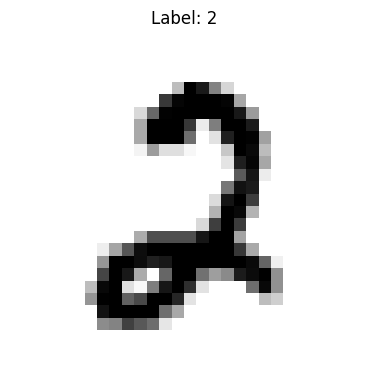

In [10]:
# Random digit
random_idx = np.random.randint(0, len(X))
print(f"Displaying random digit at index {random_idx}:")
fig, ax = plt.subplots(figsize=(4, 4))
plot_digit(X[random_idx], y[random_idx], ax)
plt.tight_layout()
plt.show()

First 25 digits from the dataset:


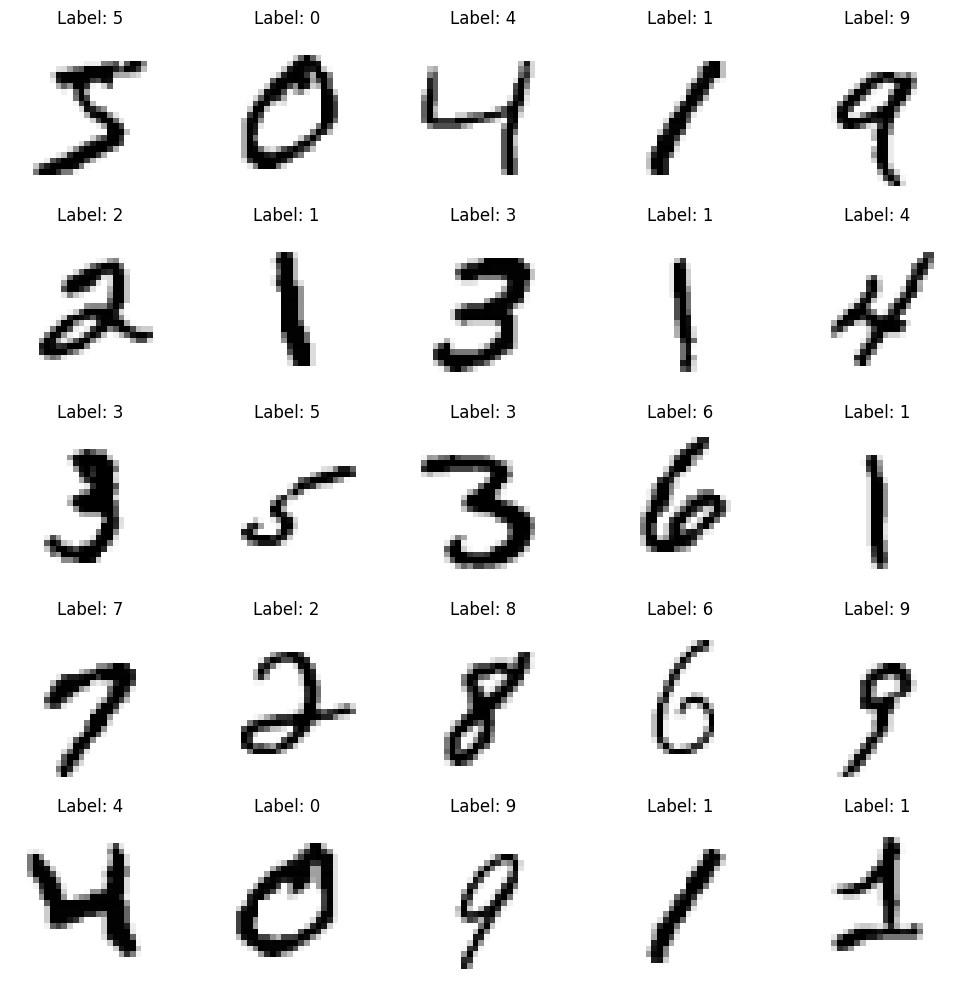

In [11]:
# Display first 25 digits
print("First 25 digits from the dataset:")
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    plot_digit(X[i], y[i], ax)
plt.tight_layout()
plt.show()

## 3. Split Dataset into Train, Cross-Validation, and Test Sets


In [12]:
# Split the dataset
print("Splitting dataset into train, cross-validation, and test sets...")

Splitting dataset into train, cross-validation, and test sets...


In [13]:
# First split: 60,000 for training, 10,000 for temp (will be split into CV and test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=5000, random_state=42, stratify=y
)

In [14]:
# Second split: Split temp into cross-validation and remaining test
X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=42, stratify=y_temp
)

In [15]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Cross-validation set: {X_cv.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 60000 samples
Cross-validation set: 5000 samples
Test set: 5000 samples


In [16]:
# Verify class distribution
print("\nClass distribution in each set:")
for set_name, y_set in [("Train", y_train), ("CV", y_cv), ("Test", y_test)]:
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"{set_name}: {dict(zip(unique, counts))}")


Class distribution in each set:
Train: {np.uint8(0): np.int64(5917), np.uint8(1): np.int64(6751), np.uint8(2): np.int64(5992), np.uint8(3): np.int64(6121), np.uint8(4): np.int64(5850), np.uint8(5): np.int64(5411), np.uint8(6): np.int64(5894), np.uint8(7): np.int64(6251), np.uint8(8): np.int64(5849), np.uint8(9): np.int64(5964)}
CV: {np.uint8(0): np.int64(493), np.uint8(1): np.int64(563), np.uint8(2): np.int64(499), np.uint8(3): np.int64(510), np.uint8(4): np.int64(487), np.uint8(5): np.int64(451), np.uint8(6): np.int64(491), np.uint8(7): np.int64(521), np.uint8(8): np.int64(488), np.uint8(9): np.int64(497)}
Test: {np.uint8(0): np.int64(493), np.uint8(1): np.int64(563), np.uint8(2): np.int64(499), np.uint8(3): np.int64(510), np.uint8(4): np.int64(487), np.uint8(5): np.int64(451), np.uint8(6): np.int64(491), np.uint8(7): np.int64(521), np.uint8(8): np.int64(488), np.uint8(9): np.int64(497)}


## 4. Train a Binary Classifier

In [17]:
# For binary classification, let's classify digit 5 vs all other digits
TARGET_DIGIT = 5

In [18]:
# Create binary labels: 1 for target digit, 0 for others
y_train_binary = (y_train == TARGET_DIGIT).astype(np.int8)
y_cv_binary = (y_cv == TARGET_DIGIT).astype(np.int8)
y_test_binary = (y_test == TARGET_DIGIT).astype(np.int8)

In [19]:
print(f"Binary classification: {TARGET_DIGIT} vs all other digits")
print(f"Training set - Class distribution: {np.unique(y_train_binary, return_counts=True)}")
print(f"CV set - Class distribution: {np.unique(y_cv_binary, return_counts=True)}")

Binary classification: 5 vs all other digits
Training set - Class distribution: (array([0, 1], dtype=int8), array([54589,  5411]))
CV set - Class distribution: (array([0, 1], dtype=int8), array([4549,  451]))


In [20]:
# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_cv_scaled = scaler.transform(X_cv.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [ ]:
# Train a Stochastic Gradient Descent classifier
#print("Training binary classifier...")
#sgd_clf = SGDClassifier(
    #random_state=42,
    #max_iter=1000,
    #tol=1e-3,
    #loss='log_loss'  # logistic regression
#)

#sgd_clf.fit(X_train_scaled, y_train_binary)

#print("Training completed!")

### Parameter tuning options and making it easier to test different configurations

In [21]:
# Train a Stochastic Gradient Descent classifier with flexible parameters
print("Training binary classifier...")

# Define parameter options for testing
sgd_params = {
    'loss': ['log_loss', 'hinge', 'modified_huber'],  # Different loss functions
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization types
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'max_iter': [1000, 2000],  # Maximum iterations
    'tol': [1e-3, 1e-4],  # Tolerance for stopping
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5]  # Initial learning rate
}

# Default parameters (you can modify these to test different configurations)
selected_params = {
    'random_state': 42,
    'loss': 'log_loss',  # logistic regression
    'penalty': 'l2',
    'alpha': 0.001,
    'max_iter': 1000,
    'tol': 1e-3,
    'learning_rate': 'optimal',
    'eta0': 0.01
}

# Create and train the classifier
sgd_clf = SGDClassifier(**selected_params)
sgd_clf.fit(X_train_scaled, y_train_binary)

print("Training completed!")
print(f"Used parameters: {selected_params}")

Training binary classifier...
Training completed!
Used parameters: {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1000, 'tol': 0.001, 'learning_rate': 'optimal', 'eta0': 0.01}


### Test multiple parameter combinations and compare results

Could take few minutes!

In [22]:
# Function to test different parameter combinations
def test_sgd_parameters(X_train, y_train, X_cv, y_cv, param_combinations):
    """
    Test different SGD parameter combinations and return results
    """
    results = []

    for i, params in enumerate(param_combinations):
        print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")

        try:
            # Create and train classifier
            clf = SGDClassifier(**params)
            clf.fit(X_train, y_train)

            # Make predictions
            y_pred = clf.predict(X_cv)
            y_pred_proba = clf.predict_proba(X_cv) if hasattr(clf, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_cv, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_cv, y_pred, average='binary', zero_division=0
            )

            results.append({
                'params': params,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'classifier': clf
            })

        except Exception as e:
            print(f"Error with parameters {params}: {e}")

    return results

# Test a few parameter combinations
print("\nTesting different parameter combinations...")

# Define some parameter combinations to test
test_combinations = [
    {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1000},
    {'random_state': 42, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0001, 'max_iter': 2000},
    {'random_state': 42, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.01, 'max_iter': 1000},
    # Added eta0 for learning_rate='adaptive'
    {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1500, 'learning_rate': 'adaptive', 'eta0': 0.01},
]

# Test the combinations
test_results = test_sgd_parameters(X_train_scaled, y_train_binary, X_cv_scaled, y_cv_binary, test_combinations)

# Display results
print("\nParameter testing results:")
print("=" * 80)
for i, result in enumerate(test_results):
    print(f"Combination {i+1}:")
    print(f"  Parameters: {result['params']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1-Score: {result['f1_score']:.4f}")
    print("-" * 40)

# Select the best classifier based on accuracy
if test_results:
    best_result = max(test_results, key=lambda x: x['accuracy'])
    sgd_clf = best_result['classifier']
    print(f"\nBest parameters: {best_result['params']}")
    print(f"Best accuracy: {best_result['accuracy']:.4f}")


Testing different parameter combinations...
Testing combination 1/4: {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1000}
Testing combination 2/4: {'random_state': 42, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0001, 'max_iter': 2000}
Testing combination 3/4: {'random_state': 42, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.01, 'max_iter': 1000}
Testing combination 4/4: {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1500, 'learning_rate': 'adaptive', 'eta0': 0.01}

Parameter testing results:
Combination 1:
  Parameters: {'random_state': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001, 'max_iter': 1000}
  Accuracy: 0.9630
  Precision: 0.8822
  Recall: 0.6807
  F1-Score: 0.7685
----------------------------------------
Combination 2:
  Parameters: {'random_state': 42, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0001, 'max_iter': 2000}
  Accuracy: 0.9716
  Precision: 0.8759
  Recall: 

### Hyperparameter tuning using GridSearchCV

In [23]:
# Optional: Hyperparameter tuning with GridSearchCV
def tune_sgd_hyperparameters(X_train, y_train, param_grid, cv=3):
    """
    Perform grid search for hyperparameter tuning
    """
    print("\nPerforming hyperparameter tuning with GridSearchCV...")

    # Create SGD classifier
    sgd = SGDClassifier(random_state=42)

    # Perform grid search
    grid_search = GridSearchCV(
        sgd, param_grid, cv=cv, scoring='accuracy',
        n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

# Define parameter grid for tuning
param_grid = {
    'loss': ['log_loss', 'hinge'],
    'penalty': ['l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 1500],
    'learning_rate': ['constant', 'optimal']
}

# Uncomment the following lines to perform hyperparameter tuning
# Note: This can be computationally intensive
best_sgd, best_params = tune_sgd_hyperparameters(
     X_train_scaled, y_train_binary, param_grid
 )
sgd_clf = best_sgd
print("Hyperparameter tuning completed!")

print("\nClassifier training and testing completed!")


Performing hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

## 5. Cross-Validate the Classifier

In [24]:
# Make predictions on cross-validation set
print("Cross-validating the classifier...")
y_cv_pred = sgd_clf.predict(X_cv_scaled)
y_cv_pred_proba = sgd_clf.predict_proba(X_cv_scaled)

Cross-validating the classifier...


In [25]:
# Calculate cross-validation accuracy
cv_accuracy = accuracy_score(y_cv_binary, y_cv_pred)
print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")

Cross-validation Accuracy: 0.9738


In [26]:
# Detailed classification report
print("\nCross-validation Classification Report:")
print(classification_report(y_cv_binary, y_cv_pred,
                          target_names=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)]))


Cross-validation Classification Report:
              precision    recall  f1-score   support

       Not 5       0.98      0.99      0.99      4549
           5       0.90      0.79      0.85       451

    accuracy                           0.97      5000
   macro avg       0.94      0.89      0.92      5000
weighted avg       0.97      0.97      0.97      5000



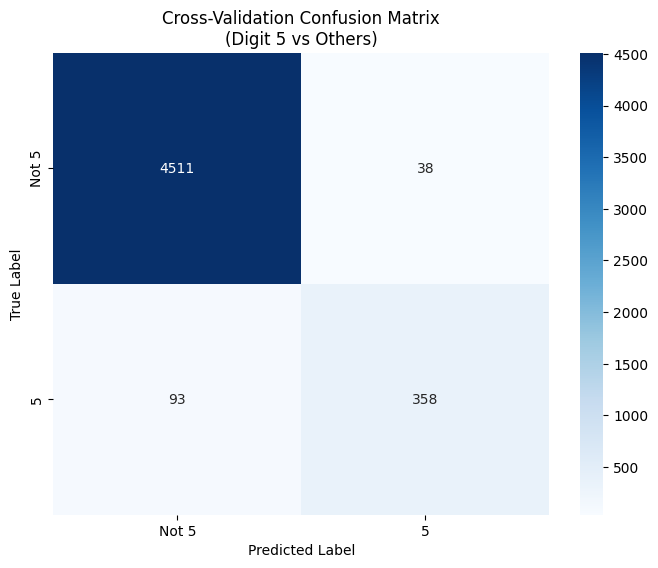

In [27]:
# Confusion matrix for cross-validation
cv_cm = confusion_matrix(y_cv_binary, y_cv_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cv_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)],
            yticklabels=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)])
plt.title(f'Cross-Validation Confusion Matrix\n(Digit {TARGET_DIGIT} vs Others)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Test the Model and Make Predictions

In [28]:
print("Testing the model on the test set...")

Testing the model on the test set...


In [29]:
# Make predictions on the test set
y_test_pred = sgd_clf.predict(X_test_scaled)
y_test_pred_proba = sgd_clf.predict_proba(X_test_scaled)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_binary, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")

# Compare with cross-validation accuracy
if abs(test_accuracy - cv_accuracy) < 0.02:
    print("✓ Model generalizes well (test accuracy close to cross-validation accuracy)")
else:
    print("⚠ Possible overfitting (significant difference between test and CV accuracy)")

Test Accuracy: 0.9778
Cross-validation Accuracy: 0.9738
✓ Model generalizes well (test accuracy close to cross-validation accuracy)


In [30]:
# Detailed classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test_binary, y_test_pred,
                          target_names=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)]))


Test Set Classification Report:
              precision    recall  f1-score   support

       Not 5       0.98      0.99      0.99      4549
           5       0.91      0.83      0.87       451

    accuracy                           0.98      5000
   macro avg       0.95      0.91      0.93      5000
weighted avg       0.98      0.98      0.98      5000



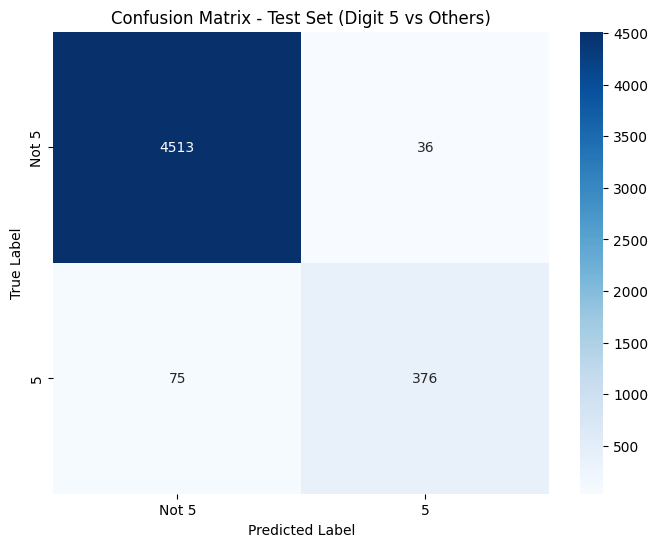

In [31]:
# Confusion matrix for test set
plt.figure(figsize=(8, 6))
test_cm = confusion_matrix(y_test_binary, y_test_pred)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)],
            yticklabels=[f'Not {TARGET_DIGIT}', str(TARGET_DIGIT)])
plt.title(f'Confusion Matrix - Test Set (Digit {TARGET_DIGIT} vs Others)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Correct predictions: 4889/5000 (97.8%)
Incorrect predictions: 111/5000 (2.2%)

Sample of correct predictions:


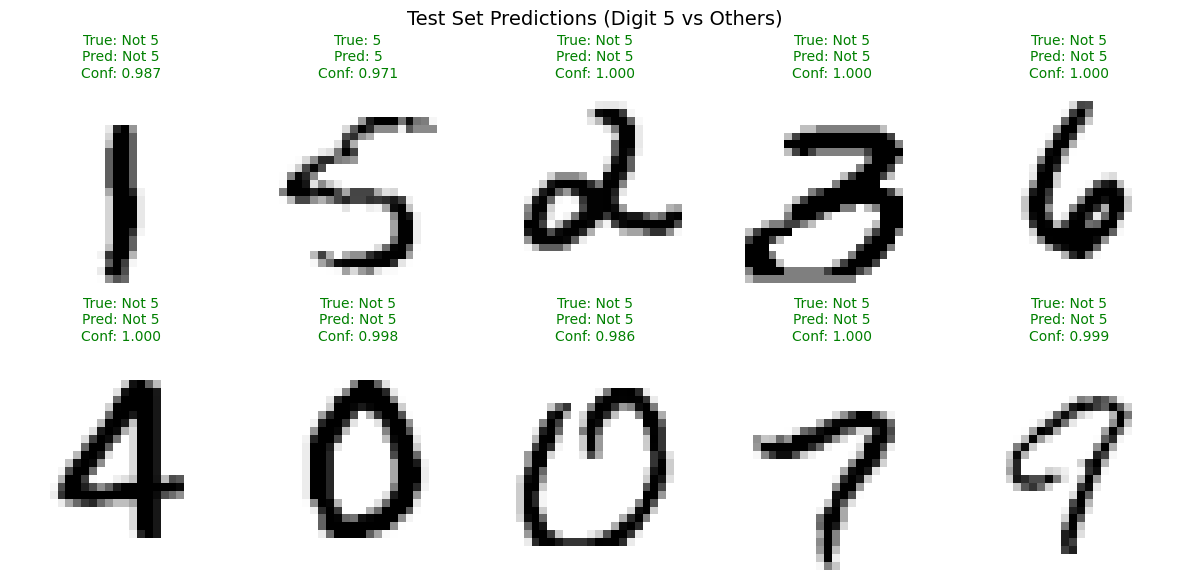


Sample of incorrect predictions:


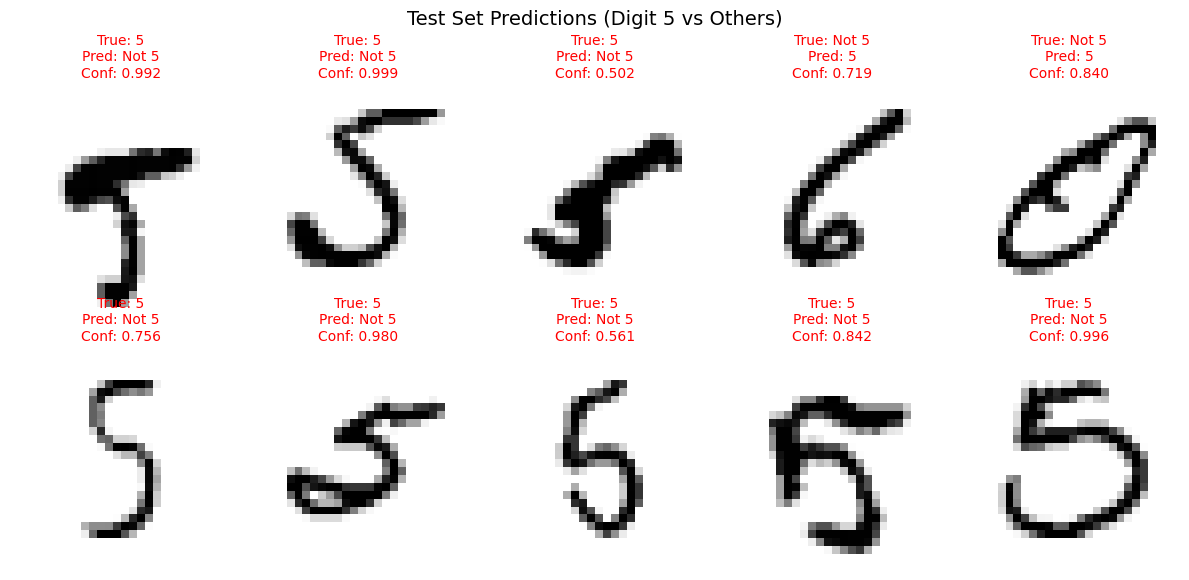

In [32]:
# Visualize some test predictions
def plot_predictions(X, y_true, y_pred, y_proba, indices):
    """Plot digits with their true and predicted labels"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(f'Test Set Predictions (Digit {TARGET_DIGIT} vs Others)', fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            idx = indices[i]
            image = X[idx].reshape(28, 28)
            ax.imshow(image, cmap='binary')

            true_label = f"5" if y_true[idx] == 1 else "Not 5"
            pred_label = f"5" if y_pred[idx] == 1 else "Not 5"
            confidence = y_proba[idx][1] if y_pred[idx] == 1 else y_proba[idx][0]

            color = 'green' if y_true[idx] == y_pred[idx] else 'red'
            ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}",
                        color=color, fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get indices of correct and incorrect predictions
correct_indices = np.where(y_test_binary == y_test_pred)[0]
incorrect_indices = np.where(y_test_binary != y_test_pred)[0]

print(f"Correct predictions: {len(correct_indices)}/{len(y_test_binary)} ({len(correct_indices)/len(y_test_binary)*100:.1f}%)")
print(f"Incorrect predictions: {len(incorrect_indices)}/{len(y_test_binary)} ({len(incorrect_indices)/len(y_test_binary)*100:.1f}%)")

# Plot some correct predictions
print("\nSample of correct predictions:")
np.random.seed(42)
sample_correct = np.random.choice(correct_indices, 10, replace=False)
plot_predictions(X_test, y_test_binary, y_test_pred, y_test_pred_proba, sample_correct)

# Plot some incorrect predictions if they exist
if len(incorrect_indices) > 0:
    print("\nSample of incorrect predictions:")
    sample_incorrect = np.random.choice(incorrect_indices, min(10, len(incorrect_indices)), replace=False)
    plot_predictions(X_test, y_test_binary, y_test_pred, y_test_pred_proba, sample_incorrect)
else:
    print("🎉 Perfect predictions on test set!")


Prediction Probability Analysis:
Average confidence for correct predictions: 0.978
Average confidence for incorrect predictions: 0.809


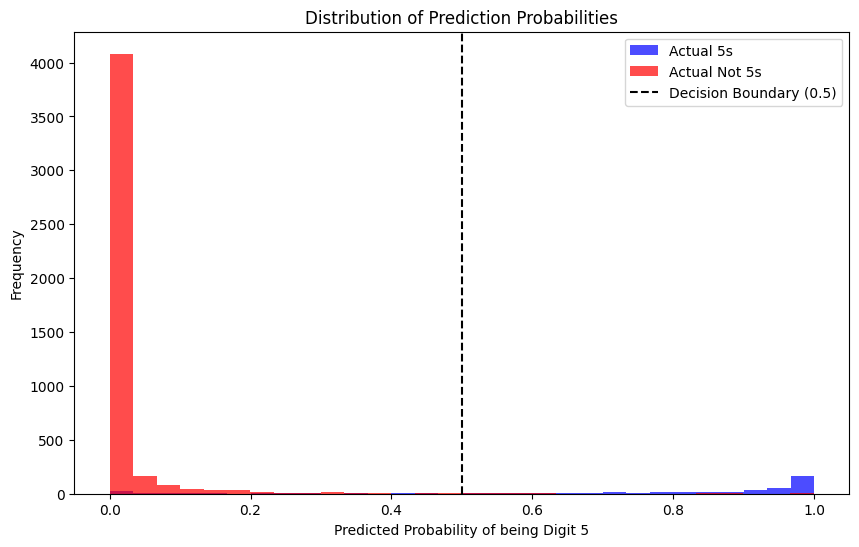

In [33]:
# Analyze prediction probabilities
print("\nPrediction Probability Analysis:")
print(f"Average confidence for correct predictions: {np.mean(y_test_pred_proba[np.arange(len(y_test_pred)), y_test_pred][y_test_binary == y_test_pred]):.3f}")
print(f"Average confidence for incorrect predictions: {np.mean(y_test_pred_proba[np.arange(len(y_test_pred)), y_test_pred][y_test_binary != y_test_pred]):.3f}")

# Plot probability distribution
plt.figure(figsize=(10, 6))
probabilities = y_test_pred_proba[:, 1]  # Probability of being digit 5

plt.hist(probabilities[y_test_binary == 1], bins=30, alpha=0.7, label=f'Actual {TARGET_DIGIT}s', color='blue')
plt.hist(probabilities[y_test_binary == 0], bins=30, alpha=0.7, label=f'Actual Not {TARGET_DIGIT}s', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('Predicted Probability of being Digit 5')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.legend()
plt.show()


TEST WITH DIFFERENT DIGIT
Enter a digit to test (0-9, current is 5): 8

Test Accuracy for digit 8: 0.8224


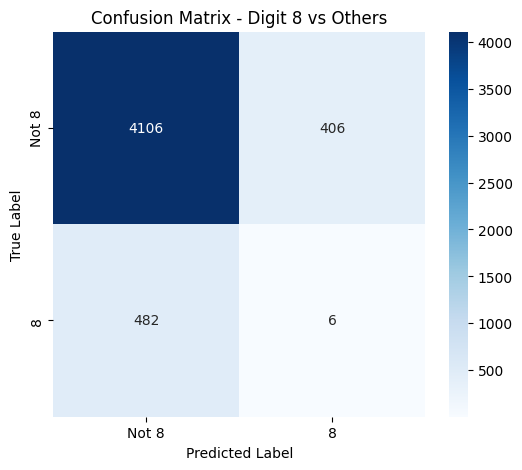


Classification Report for digit 8:
              precision    recall  f1-score   support

       Not 8       0.89      0.91      0.90      4512
           8       0.01      0.01      0.01       488

    accuracy                           0.82      5000
   macro avg       0.45      0.46      0.46      5000
weighted avg       0.81      0.82      0.82      5000



In [34]:
# Test with custom digit selection
def test_different_digit():
    """Allow testing with different target digits"""
    print("\n" + "="*50)
    print("TEST WITH DIFFERENT DIGIT")
    print("="*50)

    new_digit = int(input(f"Enter a digit to test (0-9, current is {TARGET_DIGIT}): "))

    if 0 <= new_digit <= 9:
        # Create binary labels for new digit
        y_test_new_binary = (y_test == new_digit).astype(np.int8)

        # Make predictions
        y_test_new_pred = sgd_clf.predict(X_test_scaled)
        y_test_new_pred_proba = sgd_clf.predict_proba(X_test_scaled)

        # Calculate accuracy
        new_accuracy = accuracy_score(y_test_new_binary, y_test_new_pred)
        print(f"\nTest Accuracy for digit {new_digit}: {new_accuracy:.4f}")

        # Show confusion matrix
        new_cm = confusion_matrix(y_test_new_binary, y_test_new_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(new_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[f'Not {new_digit}', str(new_digit)],
                   yticklabels=[f'Not {new_digit}', str(new_digit)])
        plt.title(f'Confusion Matrix - Digit {new_digit} vs Others')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Show classification report
        print(f"\nClassification Report for digit {new_digit}:")
        print(classification_report(y_test_new_binary, y_test_new_pred,
                                  target_names=[f'Not {new_digit}', str(new_digit)]))
    else:
        print("Invalid digit! Please enter a number between 0 and 9.")

# Uncomment the line below to enable interactive testing
test_different_digit()

In [35]:
# Final model evaluation summary
print("\n" + "="*50)
print("FINAL MODEL EVALUATION SUMMARY")
print("="*50)

print(f"Target Digit: {TARGET_DIGIT}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Cross-validation set size: {X_cv.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_test_pred, average='binary')

print(f"\nTest Set Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Overall assessment
if test_accuracy > 0.95:
    assessment = "EXCELLENT - Model performs very well"
elif test_accuracy > 0.90:
    assessment = "GOOD - Model performs well"
elif test_accuracy > 0.85:
    assessment = "FAIR - Model performs reasonably well"
else:
    assessment = "NEEDS IMPROVEMENT - Consider hyperparameter tuning"

print(f"\nOverall Assessment: {assessment}")

print("\nThe model is ready for deployment! 🚀")


FINAL MODEL EVALUATION SUMMARY
Target Digit: 5
Training set size: 60000 samples
Cross-validation set size: 5000 samples
Test set size: 5000 samples
Cross-validation Accuracy: 0.9738
Test Accuracy: 0.9778

Test Set Metrics:
Precision: 0.9126
Recall: 0.8337
F1-Score: 0.8714

Overall Assessment: EXCELLENT - Model performs very well

The model is ready for deployment! 🚀
